In [196]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from simulation.diffusion import Diffusion

import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## VIX coefficient

In [335]:
trunc = 3
e = ta.AlgebraBasis(dim=2, trunc=trunc * 2)

lam = jnp.array([5, 1])
sigma_ts = e[0] * 0.2 + e[2] * 0.5 + e[12] * 0.5 + e[222] * 3

vix_delta = 1 / 12
n_t_steps = 1000
t_grid_vix = np.linspace(0, vix_delta, n_t_steps)

esig_fm = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=vix_delta, n_points=n_t_steps, t_grid=t_grid_vix)

shuffle_table = ta.get_shuffle_table(table_trunc=trunc * 2, dim=2)
sigma_ts_sq = ta.shuffle_pow(sigma_ts, 2, shuffle_table=shuffle_table)

def get_vix_coef(sigma_sq: ta.TensorSequence, t_grid: jax.Array, esig: ta.TensorSequence, lam: jax.Array):
    return ta.from_array(
        jnp.trapezoid(
            y=ta.D_timedep(ta.right_proj_on_seq(sigma_sq, esig), t_grid, lam).array / vix_delta,
            x=t_grid, axis=1
        ),
        trunc=trunc * 2,
        dim=2
    )

vix_coef = get_vix_coef(sigma_ts_sq, t_grid_vix, esig_fm, lam)
print(vix_coef)

0.05391675112818066*0 + 0.017636545651093995*1 + 0.21429445080266593*2 + 0.011590394380847975*11 + 0.15738773940042547*12 + 0.7157776207679666*22 + 0.9200823412355082*122 + 0.5006482415890781*212 + 0.08121414194264792*221 + 1.0617562467983137*222 + 0.6321206116107818*1122 + 0.3160603058053909*1212 + 13.060904976511267*2222 + 8.442135552661487*12222 + 6.331601664496114*21222 + 4.221067776330743*22122 + 2.1105338881653717*22212 + 141.6489654603829*222222


In [336]:
T = 0.5
t_grid_W = np.linspace(0, T, int(T * 365))
rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid_W) - 1) * np.sqrt(np.diff(t_grid_W)))])
path = np.vstack([t_grid_W, W]).T
W_sig = ta.path_to_fm_signature(path=path, trunc=trunc * 2, t_grid=t_grid_W, lam=lam)
W_sig.shape

(127, 182)

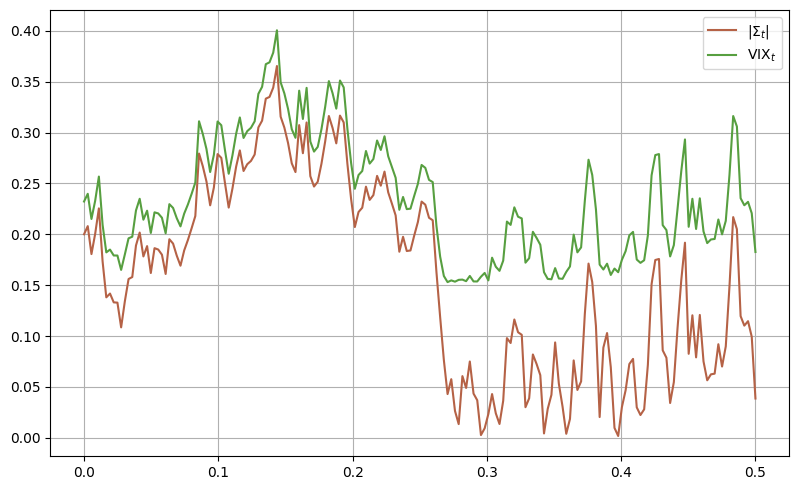

In [337]:
fig, ax = plt.subplots()

ax.plot(t_grid_W, np.abs(W_sig @ sigma_ts), label="$|\Sigma_t|$")
ax.plot(t_grid_W, np.sqrt(W_sig @ vix_coef), label="$\mathrm{VIX}_t$")
ax.legend()

£#### Sanity check
$\mathbb{E}[\mathrm{VIX}_T^2] = \langle \ell^{\mathrm{VIX}^2}, \mathcal{E}^{\lambda}_T \rangle = \dfrac{1}{\Delta}\int_0^\Delta \langle \sigma^{2}, \mathcal{E}_{T + u}^\lambda\rangle du$

In [338]:
esig_T = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=T, n_points=1000)
vix_coef @ esig_T

Array(0.44643163, dtype=float64)

In [339]:
esig_vix_grid = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=T, t_grid=np.concatenate([t_grid_W, T + t_grid_vix]))
np.trapz(esig_vix_grid.array[:, t_grid_W.size:].T @ sigma_ts_sq.array, t_grid_vix) / vix_delta

0.4464247997262932

In [340]:
# Reproduce it with Monte Carlo
# VIX Futures
# ATM options on VIX

In [341]:
def payoff_vix_squared(vix_squared):
    return vix_squared

def payoff_vix(vix_squared):
    return np.sqrt(vix_squared)

def payoff_call_on_vix(vix_squared, K):
    return np.maximum(np.sqrt(vix_squared) - K, 0)

In [342]:
payoff = payoff_vix_squared

In [343]:
from tqdm import tqdm
from simulation.monte_carlo import MonteCarlo

# simulation of B_traj
batch_size = 10**3
rng = np.random.default_rng(seed=42)
t_grid_mc = np.linspace(0, T, int(T * 52))

n_batches = 10

mc_vix_square = None
for _ in range(n_batches):
    diffusion = Diffusion(t_grid=t_grid_mc, dim=1, size=batch_size, rng=rng)
    W_traj = diffusion.brownian_motion()[:, 0, :]  # shape (size, len(t_grid))

    path = np.zeros((diffusion.t_grid.size, 2, batch_size))
    path[:, 0, :] = np.reshape(diffusion.t_grid, (-1, 1))
    path[:, 1, :] = W_traj.T

    array = np.zeros((ta.number_of_words_up_to_trunc(trunc=sigma_ts.trunc, dim=sigma_ts.dim), path.shape[0], path.shape[2]))
    for i in tqdm(range(path.shape[2])):
        array[:, :, i] = ta.path_to_fm_signature(path=path[:, :, i], trunc=sigma_ts.trunc, t_grid=diffusion.t_grid, lam=lam).array
    W_sig_batch = ta.from_array(array, trunc=sigma_ts.trunc, dim=sigma_ts.dim)
    vix_squared_batch = vix_coef.array @ W_sig_batch.array[:, -1, :]

    if mc_vix_square is None:
        mc_vix_square = MonteCarlo(payoff(vix_squared_batch), confidence_level=0.95)
    else:
        mc_vix_square.add_batch(payoff(vix_squared_batch))
    print(mc_vix_square.results())

100%|██████████| 1000/1000 [00:24<00:00, 41.18it/s]


0.44922000000000006 ± 0.06999


100%|██████████| 1000/1000 [00:23<00:00, 42.12it/s]


0.44906 ± 0.05136


100%|██████████| 1000/1000 [00:22<00:00, 43.69it/s]


0.45595 ± 0.05895


100%|██████████| 1000/1000 [00:22<00:00, 44.03it/s]


0.45937000000000006 ± 0.04803


100%|██████████| 1000/1000 [00:22<00:00, 43.83it/s]


0.45675000000000004 ± 0.0407


100%|██████████| 1000/1000 [00:22<00:00, 43.85it/s]


0.44992000000000004 ± 0.03527


100%|██████████| 1000/1000 [00:22<00:00, 44.08it/s]


0.45752000000000004 ± 0.03242


100%|██████████| 1000/1000 [00:22<00:00, 44.08it/s]


0.45033000000000006 ± 0.02946


100%|██████████| 1000/1000 [00:22<00:00, 43.96it/s]


0.45182000000000005 ± 0.02964


100%|██████████| 1000/1000 [00:22<00:00, 44.04it/s]

0.45512 ± 0.03006


## Cubatures

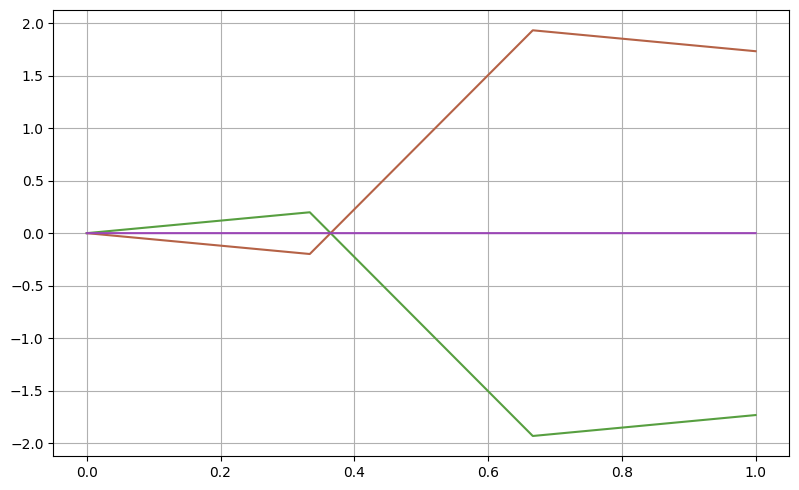

In [323]:
t = np.linspace(0, 1, 10000)

omega1 = ((t <= 1 / 3) * 0.5 * (4 - np.sqrt(22)) * t +
          (t > 1 / 3) * (t <= 2 / 3) * ((4 - np.sqrt(22)) / 6 + (-1 + np.sqrt(22)) * (t - 1 / 3)) +
          (t > 2 / 3) * ((2 + np.sqrt(22)) / 6 + 0.5 * (4 - np.sqrt(22)) * (t - 2 / 3)))

plt.plot(t, omega1 * np.sqrt(3))
plt.plot(t, -omega1 * np.sqrt(3))
plt.plot(t, np.zeros_like(t))

In [324]:
path = np.array(
   [
    [[0, 0],
     [1/3, np.sqrt(3) / 6 * (4 - np.sqrt(22))],
     [2/3, np.sqrt(3) / 6 * (2 + np.sqrt(22))],
     [1, np.sqrt(3)]],
    [[0, 0],
     [1/3, -np.sqrt(3) / 6 * (4 - np.sqrt(22))],
     [2/3, -np.sqrt(3) / 6 * (2 + np.sqrt(22))],
     [1, -np.sqrt(3)]],
    [[0, 0],
     [1/3, 0],
     [2/3, 0],
     [1, 0]]
   ]
)
cubature_weights = np.array([1/6, 1/6, 2/3])
n_cubature = len(cubature_weights)


tree_sig = np.zeros((ta.number_of_words_up_to_trunc(trunc=sigma_ts.trunc, dim=sigma_ts.dim), n_cubature))


def dilation(path, T):
    new_path = np.zeros_like(path)
    new_path[:, 0] = T * path[:, 0]
    new_path[:, 1] = np.sqrt(T) * path[:, 1]
    return new_path

K = 14
dT = T / K

for i in range(3):
    scaled_path = dilation(path[i, :, :], dT)
    tree_sig[:, i] = ta.path_to_fm_signature(scaled_path, trunc=sigma_ts.trunc, t_grid=scaled_path[:, 0], lam=lam).array[:, -1]
cubature_sig = ta.from_array(tree_sig, trunc=sigma_ts.trunc, dim=sigma_ts.dim)

In [325]:
iterated_cubature = cubature_sig
iterated_cubature_weights = cubature_weights

for l in range(K - 1):
    print(l)
    prev_tree_size = iterated_cubature.array.shape[1]
    new_array = np.zeros((iterated_cubature.array.shape[0], prev_tree_size * n_cubature))
    iterated_cubature_weights = np.outer(cubature_weights, iterated_cubature_weights).flatten()
    for k in range(n_cubature):
        new_array[:, prev_tree_size * k: prev_tree_size* (k+1)] = ta.tensor_prod(
            ta.D(iterated_cubature, dt=dT, lam=lam),
            cubature_sig.subsequence((k, ))
        ).array
    iterated_cubature = ta.from_array(new_array, trunc=sigma_ts.trunc, dim=sigma_ts.dim)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [326]:
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

Array(0.4301654, dtype=float64)

In [331]:
path = np.array(
   [
    [[0, 0],
     [1.0, 1.0]],
    [[0, 0],
     [1.0, -1.0]],
   ]
)

cubature_weights = np.array([0.5, 0.5])
n_cubature = len(cubature_weights)
tree_sig = np.zeros((ta.number_of_words_up_to_trunc(trunc=sigma_ts.trunc, dim=sigma_ts.dim), n_cubature))

K = 22
dT = T / K

for i in range(n_cubature):
    scaled_path = dilation(path[i, :, :], dT)
    tree_sig[:, i] = ta.path_to_fm_signature(scaled_path, trunc=sigma_ts.trunc, t_grid=scaled_path[:, 0], lam=lam).array[:, -1]
cubature_sig = ta.from_array(tree_sig, trunc=sigma_ts.trunc, dim=sigma_ts.dim)

In [332]:
n_cubature**K

4194304

In [333]:
iterated_cubature = cubature_sig
iterated_cubature_weights = cubature_weights

for l in range(K - 1):
    print(l)
    prev_tree_size = iterated_cubature.array.shape[1]
    new_array = np.zeros((iterated_cubature.array.shape[0], prev_tree_size * n_cubature))
    iterated_cubature_weights = np.outer(cubature_weights, iterated_cubature_weights).flatten()
    for k in range(n_cubature):
        new_array[:, prev_tree_size * k: prev_tree_size* (k+1)] = ta.tensor_prod(
            ta.D(iterated_cubature, dt=dT, lam=lam),
            cubature_sig.subsequence((k, ))
        ).array
    iterated_cubature = ta.from_array(new_array, trunc=sigma_ts.trunc, dim=sigma_ts.dim)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [334]:
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

Array(0.41624116, dtype=float64)

In [60]:
 # order 5 cubature
K = 12
dT = 1 / K

e = ta.AlgebraBasis(dim=2, trunc=trunc)
v11 = e[1] * dT + e[2] * np.sqrt(3) / 2 * (4 - np.sqrt(22)) * np.sqrt(dT)
v12 = e[1] * dT + e[2] * np.sqrt(3) * (-1 + np.sqrt(22)) * np.sqrt(dT)

v21 = e[1] * dT + e[2] * np.sqrt(3) / 2 * (4 - np.sqrt(22)) * (-1) * np.sqrt(dT)
v22 = e[1] * dT + e[2] * np.sqrt(3) * (-1 + np.sqrt(22)) * (-1) * np.sqrt(dT)

sig_v11 = ta.tensor_exp(v11 / 3)
sig_v12 = ta.tensor_exp(v12 / 3)
sig_1 = ta.tensor_prod(
    ta.tensor_prod(sig_v11, sig_v12),
    sig_v11
)

sig_v21 = ta.tensor_exp(v21 / 3)
sig_v22 = ta.tensor_exp(v22 / 3)
sig_2 = ta.tensor_prod(
    ta.tensor_prod(sig_v21, sig_v22),
    sig_v21
)

sig_3 = ta.tensor_exp(e[1] * dT)

p1, p2, p3 = 1 / 6, 1 / 6, 2 / 3

cubature_mean = sig_1 * p1 + sig_2 * p2 + sig_3 * p3

In [13]:
# simple binomial tree
K_tree = 20
dT = 1 / K_tree

e = ta.AlgebraBasis(dim=2, trunc=trunc)
v_up = e[1] * dT + e[2] * np.sqrt(dT)
v_down = e[1] * dT + e[2] * np.sqrt(dT) * (-1)

sig_up = ta.tensor_exp(v_up)
sig_down = ta.tensor_exp(v_down)

cubature_mean_tree = sig_up * 0.5 + sig_down * 0.5